In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv


# Let's explore the datasets
### Starting from the URM
The URM contains a user for each row and an item for each column

In [2]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")
URM_all_dataframe.head(10)

,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [3]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 1764607


In [4]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735



In [5]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [6]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))
URM_all_dataframe.head(n=10)

New index for item 292 is 17024


,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [7]:
URM_all_dataframe["user_id"] = URM_all_dataframe["user_id"].map(user_original_ID_to_index)
URM_all_dataframe["item_id"] = URM_all_dataframe["item_id"].map(item_original_ID_to_index)

In [8]:
URM_all_dataframe.head(n=10)

,user_id,item_id,data
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [9]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735

Average interactions per user 49.38
Average interactions per item 46.29

Sparsity 99.87 %


In [10]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)))

URM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [11]:
URM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [12]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 1254, 1310, 1470], dtype=int32)

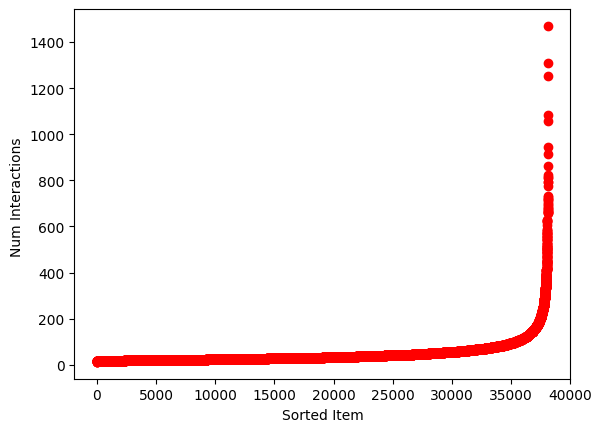

In [13]:
plt.plot(item_popularity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted Item')
plt.show()

In [14]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 46.29
Average per-item interactions for the top 10% popular items 153.63
Average per-item interactions for the least 10% popular items 17.95
Average per-item interactions for the median 10% popular items 31.50


In [15]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


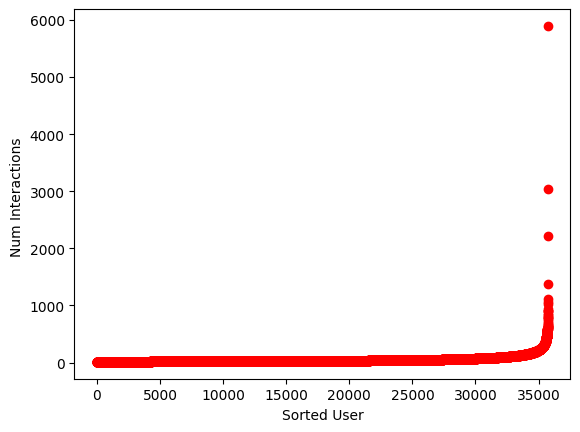

In [16]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

# Let's study the ICM

In [17]:
ICM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")
ICM_all_dataframe.head(10)

,item_id,feature_id,data
0,2519,0,1.0
1,2642,0,1.0
2,3316,0,1.0
3,3400,0,1.0
4,3472,0,1.0
5,4361,0,1.0
6,4661,0,1.0
7,8697,0,1.0
8,9692,0,1.0
9,9693,0,1.0


In [18]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

In [19]:
n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))

Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330



In [20]:
mapped_id, original_id = pd.factorize(ICM_all_dataframe["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all_dataframe["item_id"].unique())
item_original_ID_to_index_ICM = pd.Series(mapped_id, index=original_id)

In [21]:
ICM_all_dataframe["feature_id"] = ICM_all_dataframe["feature_id"].map(feature_original_ID_to_index)
ICM_all_dataframe["item_id"] = ICM_all_dataframe["item_id"].map(item_original_ID_to_index_ICM)

In [22]:
ICM_all_dataframe.head(n=10)

,item_id,feature_id,data
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0
5,5,0,1.0
6,6,0,1.0
7,7,0,1.0
8,8,0,1.0
9,9,0,1.0


In [23]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))
print ("Average interactions per feature {:.2f}".format(n_interactions_ICM/n_features))
print ("Average interactions per item {:.2f}\n".format(n_interactions_ICM/n_items_ICM))

print ("Sparsity {:.2f} %".format((1-float(n_interactions_ICM)/(n_items_ICM*n_features))*100))


Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330

Average interactions per feature 31.17
Average interactions per item 77.12

Sparsity 99.92 %


In [24]:
ICM_all = sps.coo_matrix((ICM_all_dataframe["data"].values, (ICM_all_dataframe["item_id"].values,ICM_all_dataframe["feature_id"].values)))


ICM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [25]:
ICM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [26]:
item_popularity_ICM = np.ediff1d(ICM_all.tocsr().indptr)       # tocsc(), when rows and columns inverted
item_popularity_ICM = np.sort(item_popularity_ICM)
item_popularity_ICM 

array([   1,    1,    1, ..., 1084, 1199, 2013], dtype=int32)

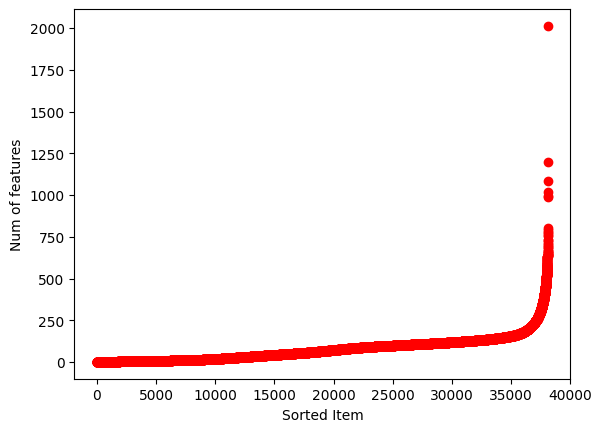

In [27]:
plt.plot(item_popularity_ICM, 'ro')
plt.ylabel('Num of features')
plt.xlabel('Sorted Item')
plt.show()

In [28]:
ten_percent = int(n_items_ICM/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity_ICM.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity_ICM[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity_ICM[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity_ICM[int(n_items_ICM*0.45):int(n_items_ICM*0.55)].mean()))

Average per-item interactions over the whole dataset 77.12
Average per-item interactions for the top 10% popular items 228.64
Average per-item interactions for the least 10% popular items 3.77
Average per-item interactions for the median 10% popular items 65.90


# Creating a validation set for testing our recommendation models

In [29]:
train_test_split = 0.80

n_interactions = URM_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [30]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1410873 stored elements and shape (35736, 38121)>

In [31]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 353734 stored elements and shape (35736, 38121)>

In [32]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([ 242,  268,  458, 4885, 5554, 5724, 6089, 6906, 8247, 8249, 8251,
       8259, 8268, 8269, 8270, 8272, 8274, 8275, 8278, 8280, 8289, 8292,
       8298, 8302, 8309, 8311, 8316, 8320, 8324, 8326, 8328, 8329, 8330,
       8332, 8333, 8336, 8337, 8349, 8359, 8364, 8368, 8371, 8372, 8375],
      dtype=int32)